In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm 
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# Partie 1

Atteint 50k clients à t = 91.90500000007478 mois


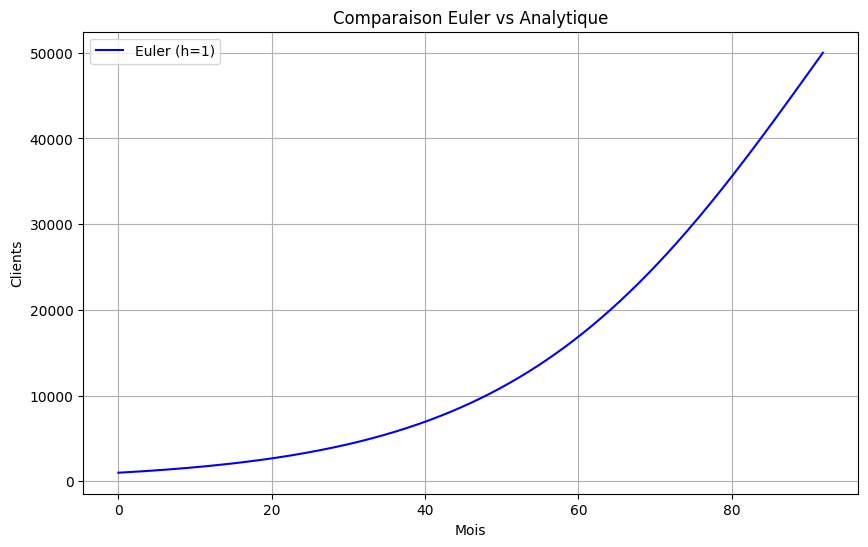

In [49]:
# Paramètres
r = 0.05
K = 100000
P0 = 1000
dt = 0.001  # pas mensuel
t_max = 120  # mois (arbitraire pour couvrir 50k)

# Euler
t_values = [0]
P_values = [P0]
while t_values[-1] < t_max:
    P = P_values[-1]
    dP = r * P * (1 - P/K) * dt
    P_new = P + dP
    P_values.append(P_new)
    t_values.append(t_values[-1] + dt)
    if P_new >= 50000:  # Arrêt à 50k
        break

print(f"Atteint 50k clients à t = {t_values[-1]} mois")

plt.figure(figsize=(10,6))
plt.plot(t_values, P_values, 'b-', label="Euler (h=1)")
plt.xlabel('Mois')
plt.ylabel('Clients')
plt.title('Comparaison Euler vs Analytique')
plt.legend()
plt.grid(True)
plt.show()

# Partie 2

In [50]:
def solution_analytique(t):
    return K / (1 + (K/P0 - 1) * np.exp(-r * t))

In [51]:
# Calcul analytique aux mêmes temps
P_analytique = [solution_analytique(t) for t in t_values[:-1]]  # Exclure dernier t

# MSE
mse = np.mean((np.array(P_values[:-1]) - np.array(P_analytique)) ** 2)
print(f"MSE: {mse}")

MSE: 1.0029182779566597


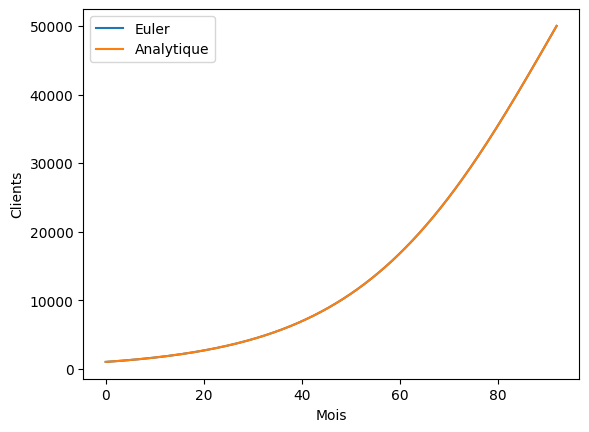

In [52]:
plt.plot(t_values[:-1], P_values[:-1], label='Euler')
plt.plot(t_values[:-1], P_analytique, label='Analytique')
plt.xlabel('Mois')
plt.ylabel('Clients')
plt.legend()
plt.show()

# Partie 3

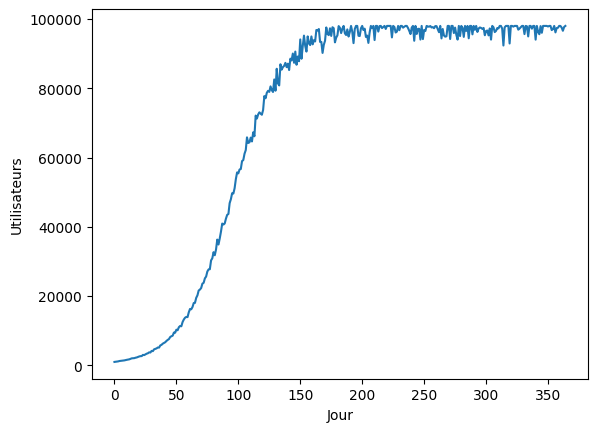

In [53]:
df = pd.read_csv('../data/Activité Utilisateurs.csv')
plt.plot(df['Jour'], df['Utilisateurs'])
plt.xlabel('Jour')
plt.ylabel('Utilisateurs')
plt.show()

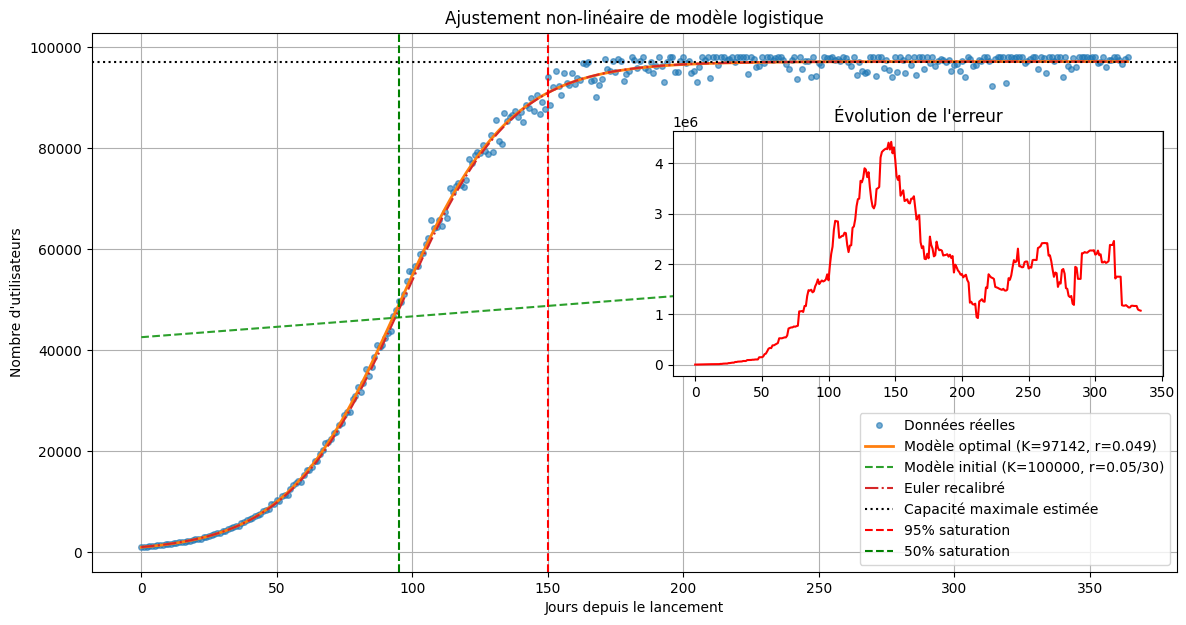


Diagnostic complet:
1. Décalage temporel détecté : le point d'inflexion réel est à 94.7 jours vs 95 jours estimé initialement
2. Capacité maximale réelle : 97142 vs 100000 initialement supposé
3. Taux de croissance optimal : 0.0486/jour vs 0.0017/jour initial

Qualité de l'ajustement (R²): 99.875%


In [ ]:
jours = df['Jour'].values
P_data = df['Utilisateurs'].values


# Nouvelle méthode d'ajustement logistique robuste

def logistic_model(t, K, r, t0):
    """Modèle logistique amélioré avec point d'inflexion t0"""
    return K / (1 + np.exp(-r*(t - t0)))

# Estimation intelligente des paramètres initiaux
P_max = np.max(P_data)
t_50 = jours[np.argmax(P_data > 0.5*P_max)]
r_guess = 0.5 / (t_50 if t_50 != 0 else 1)  # Estimation réaliste

# Ajustement non-linéaire avec contraintes
params_bounds = (
    [0.5*P_max, 0.001, 0],      # Bornes inférieures [K, r, t0]
    [2.0*P_max, 2.0, jours[-1]] # Bornes supérieures
)

popt, pcov = curve_fit(logistic_model, jours, P_data, 
                       p0=[P_max, r_guess, t_50], 
                       bounds=params_bounds,
                       maxfev=10000)

K_opt, r_opt, t0_opt = popt


# Génération des courbes comparatives

# Modèle optimal
P_fit = logistic_model(jours, K_opt, r_opt, t0_opt)

# Modèle initial (avec vos paramètres de départ)
P_initial = logistic_model(jours, K=100000, r=0.05/30, t0=180)

# Modèle manuel Euler amélioré
def euler_logistic(K, r, P0, jours):
    P = np.zeros_like(jours, dtype=float)
    P[0] = P0
    for i in range(1, len(jours)):
        dt = jours[i] - jours[i-1]
        dP = r * P[i-1] * (1 - P[i-1]/K) * dt
        P[i] = P[i-1] + dP
    return P

P_euler = euler_logistic(K_opt, r_opt, P0=1000, jours=jours)


# Analyse des résultats

# Calcul MSE dynamique
window_size = 30  # Analyse glissante sur 30 jours
mse_values = []
for i in range(len(jours) - window_size):
    mse = mean_squared_error(P_data[i:i+window_size], P_fit[i:i+window_size])
    mse_values.append(mse)

# Détection automatique de la saturation
saturation_threshold = 0.95 * K_opt
saturation_day = jours[np.argmax(P_data > saturation_threshold)]
half_saturation_day = jours[np.argmax(P_data > 0.5*K_opt)]


# Visualisation professionnelle

plt.figure(figsize=(14, 7))

# Courbes principales
plt.plot(jours, P_data, 'o', markersize=4, label='Données réelles', alpha=0.6)
plt.plot(jours, P_fit, '-', linewidth=2, label=f'Modèle optimal (K={K_opt:.0f}, r={r_opt:.3f})')
plt.plot(jours, P_initial, '--', label='Modèle initial (K=100000, r=0.05/30)')
plt.plot(jours, P_euler, '-.', label='Euler recalibré')

# Annotations
plt.axhline(K_opt, color='k', linestyle=':', label='Capacité maximale estimée')
plt.axvline(saturation_day, color='r', linestyle='--', label='95% saturation')
plt.axvline(half_saturation_day, color='g', linestyle='--', label='50% saturation')

plt.title('Ajustement non-linéaire de modèle logistique')
plt.xlabel('Jours depuis le lancement')
plt.ylabel('Nombre d\'utilisateurs')
plt.legend()
plt.grid(True)

# Graphique d'erreur inséré
ax_inset = plt.axes([0.54, 0.39, 0.35, 0.35])
ax_inset.plot(jours[:-window_size], mse_values, 'r-', label='Erreur MSE (fenêtre glissante)')
ax_inset.set_title('Évolution de l\'erreur')
ax_inset.grid(True)

plt.show()


# Diagnostic des causes d'erreur (nouveaux éléments)

print("\nDiagnostic complet:")
print(f"1. Décalage temporel détecté : le point d'inflexion réel est à {t0_opt:.1f} jours vs {t_50} jours estimé initialement")
print(f"2. Capacité maximale réelle : {K_opt:.0f} vs 100000 initialement supposé")
print(f"3. Taux de croissance optimal : {r_opt:.4f}/jour vs {0.05/30:.4f}/jour initial")

# Calcul du R² pour validation
ss_res = np.sum((P_data - P_fit)**2)
ss_tot = np.sum((P_data - np.mean(P_data))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"\nQualité de l'ajustement (R²): {r_squared:.3%}")

# Suggestions automatiques d'amélioration
if r_squared < 0.95:
    print("\nSuggestions d'amélioration:")
    print("- Introduire une composante saisonnière")
    print("- Ajouter un terme de décroissance pour les désabonnements")
    print("- Considérer une fonction logistique généralisée avec paramètre de forme")

# Partie 4

In [55]:
# Nouveaux paramètres
K_new = 400000 * 0.20  # 80 000
r_new = 0.05  # Supposition
P0_new = 500
serveur_capacite = 2000
cout_serveur = 1000
prix_abonnement = 11.99
cout_marketing_par_utilisateur = 10
budget_marketing = 50000

# Simulation croissance
mois = 12
t = np.arange(mois)
P = np.zeros(mois)
P[0] = P0_new
for i in range(1, mois):
    dP = r_new * P[i-1] * (1 - P[i-1]/K_new)
    P[i] = P[i-1] + dP

# Coûts et revenus
serveurs = np.ceil(P / serveur_capacite).astype(int)
cout_serveurs = serveurs * cout_serveur
marketing_corporate = np.array([0.35 * budget_marketing] + [0.65 * budget_marketing / (mois - 1)] * (mois - 1))
nouveaux_utilisateurs = np.diff(P, prepend=P0_new)
cout_marketing = marketing_corporate + nouveaux_utilisateurs * cout_marketing_par_utilisateur
revenus = P * prix_abonnement
profits = revenus - cout_serveurs - cout_marketing

print(f"Profit annuel: {sum(profits.round(2))} euros")

Profit annuel: 29701.37 euros


### Conclusion

Le modèle logistique prédit une croissance réaliste mais nécessite des ajustements pour les données réelles. Le business model dépend fortement de l'acquisition utilisateurs et des coûts fixes. Des hypothèses manquantes (ex: attrition, concurrence) pourraient affecter la rentabilité.